<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/edgar/Rakuten_py_NLP_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize

from datetime import datetime

Récuperer les données:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Initialiser la variable des mots vides
stop_words = set(stopwords.words('french'))
 
df_X = pd.read_csv('/content/drive/My Drive/Rakuten/X_train_update.csv',index_col=0)
df_y = pd.read_csv('/content/drive/My Drive/Rakuten/Y_train_CVw08PX.csv',index_col=0)

In [5]:
lemmatizer = WordNetLemmatizer()

def lemma(sentence): #Lemmatizer
    doc = word_tokenize(sentence, language='french')
    return [lemmatizer.lemmatize(token) for token in doc]

def stop_words_filetring(mots) : 
    tokens = []
    for mot in mots:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens

def clean_text(text):
    string = ''
    words = word_tokenize(text.lower(), language='french')
    for word in words:
        if word not in stop_words:
            if word.isascii() and word.isalpha():
              string += lemmatizer.lemmatize(word) + ' '
    return string

On netoye un peu le texte:

In [6]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
X = df_X.designation.astype(str) + ' ' + df_X.description.astype(str)
y = df_y.prdtypecode

X_clean = X.apply(lambda cell: clean_text(cell))
X_clean

0        olivia personalisiertes notizbuch seiten punkt...
1        journal art marche salon asiatique a paris jac...
2        grand stylet ergonomique bleu gamepad nintendo...
3        peluche donald europe disneyland marionnette d...
4        guerre tuques luc a id eacute grandeur veut or...
                               ...                        
84911                         the sims import anglais nan 
84912    kit piscine acier nevada pierre x b descriptio...
84913    journal officiel republique francaise changeme...
84914    table basse bois massif base blanche p cette t...
84915    gomme collection gommes pinguin glace vert ora...
Length: 84916, dtype: object

Combien de mots uniques?

In [8]:
lis = []
for element in X_clean.str.split():
    for word in element:
        lis.append(word)

len(list(set(lis)))

99865

Transformer les categories en numeros de 0 à 26:

In [9]:
categories = list(set(y.to_list()))
y_trans = y
i = 0
for category in categories:
    y_trans = y_trans.replace(category,i)
    i+=1

y_trans

0         4
1        25
2        20
3         0
4         6
         ..
84911    17
84912    10
84913    25
84914    11
84915    23
Name: prdtypecode, Length: 84916, dtype: int64

Separer en train et test

In [10]:
# Importer la classe train_test 
from sklearn.model_selection import train_test_split

# Séparer le jeu de données en données d'entraînement et données test 
X, X_valid, y, y_valid = train_test_split(X_clean, y_trans,train_size=0.05, test_size=0.01)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Validation size is',y_train.size ,'test size is', y_test.size, 'and validation size is', y_valid.size)

Validation size is 3396 test size is 849 and validation size is 850


Vectoriser avec TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(analyzer='word',
                  tokenizer=word_tokenize,
                      #strip_accents='unicode',
                      #stop_words=french_stop_words_no_accent, # peut etre interessant parce que lisse la progression
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  )

X_train = tfid.fit_transform(X_train).todense()
X_test = tfid.transform(X_test).todense()
X_valid = tfid.transform(X_valid).todense()

Vectoriser avec CountVectoriser:

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser un objet vectorisateur
#vectorizer = CountVectorizer()

# Mettre à jour la valeur de X_train et X_test
#X_train = vectorizer.fit_transform(X_train).todense()
#X_test = vectorizer.transform(X_test).todense()

Utiliser modèle XGBoost:

In [38]:
import xgboost as xgb

train = xgb.DMatrix(X_train,y_train)
test = xgb.DMatrix(X_test,y_test)
valid = xgb.DMatrix(X_valid,y_valid)

In [39]:


params = {'booster':'gbtree', 'learning_rate': 1,'objective':'multi:softmax','num_class':27}

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

xgb1 = xgb.train(params = params,
                 dtrain = train,
                 num_boost_round= 100,
                 early_stopping_rounds= 5,
                 evals= [(train, 'train'), (test, 'eval')])

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 12:30:22
[0]	train-merror:0.392815	eval-merror:0.492344
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 5 rounds.
[1]	train-merror:0.35424	eval-merror:0.506478
[2]	train-merror:0.270612	eval-merror:0.454653
[3]	train-merror:0.220259	eval-merror:0.435807
[4]	train-merror:0.196408	eval-merror:0.42874
[5]	train-merror:0.169317	eval-merror:0.427562
[6]	train-merror:0.15106	eval-merror:0.419317
[7]	train-merror:0.138104	eval-merror:0.425206
[8]	train-merror:0.127503	eval-merror:0.414605
[9]	train-merror:0.114547	eval-merror:0.413428
[10]	train-merror:0.109835	eval-merror:0.411072
[11]	train-merror:0.104829	eval-merror:0.413428
[12]	train-merror:0.098057	eval-merror:0.411072
[13]	train-merror:0.091284	eval-merror:0.413428
[14]	train-merror:0.088339	eval-merror:0.411072
[15]	train-merror:0.081272	eval-merror:0.408716
[16]	train-merror:0.077739	eval-merror:0.407538
[17]	train-merror:0.074205	ev

Un peu trop d'overfitting

Analyse predictions:

In [40]:
preds = pd.Series(xgb1.predict(valid).astype(int))
import numpy as np

y_valid.index = np.arange(0,len(y_valid))
y_valid

pd.crosstab(preds,y_valid)

prdtypecode,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18,2,0,0,0,0,0,3,0,3,0,0,3,0,0,1,0,1,2,0,0,0,1,2,0,0,1
1,2,6,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,33,0,0,4,0,0,0,1,0,4,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
3,0,3,0,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,2,1,1
4,1,2,0,3,15,1,5,3,0,0,1,0,1,1,0,0,3,3,2,0,1,0,0,5,8,7,1
5,2,1,2,0,0,29,0,0,0,3,0,3,1,1,0,0,0,0,4,0,1,0,0,1,0,0,0
6,1,1,0,0,3,0,11,0,0,0,1,0,1,1,0,2,0,1,1,0,0,0,0,0,2,1,4
7,7,0,0,0,1,0,0,32,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
8,1,0,0,0,0,0,1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


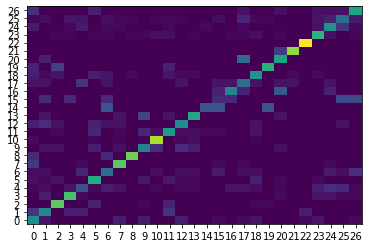

In [41]:
import matplotlib.pyplot as plt

df = pd.crosstab(preds,y_valid)
somme = df.apply(np.sum,axis=1)

#ponderation par ligne
df = df.apply(lambda cell: cell/somme[cell.index])

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

On observe que la classe 14 n'a pas été très bien classifié

In [18]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

#params = {'booster':['gbtree'], 'learning_rate': [0.2,0.5],'n_estimators': [100,200],'objective':['multi:softmax'],'num_class':[27]}

learning_rate = [ 0.01, 0.1, 0.3]

param_grid = {'learning_rate': learning_rate,
     #'n_estimators': [50,100,300]
}

xgb_model = xgb.XGBClassifier()

gridCV = GridSearchCV(xgb_model,params,scoring='accuracy',cv=3,return_train_score=True, verbose = 2)

In [ ]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

gridCV.fit(X_train,y_train)

current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 13:57:53
